In [1]:
import sys
print(sys.executable)

/Users/japleenkaur/qiskit/anaconda3/envs/hackathon/bin/python


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
# Set environment
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import json
import time
from datetime import datetime
from pathlib import Path
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
print(" All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ All libraries imported successfully!
TensorFlow version: 2.15.0
GPU Available: False


In [ ]:
# Configuration
DATASET_PATH = '/Users/japleenkaur/Downloads/dataset_grayscale'  # Change this if your dataset is elsewhere

print("="*70)
print("DATASET ANALYSIS")
print("="*70)


class_folders = sorted([d for d in os.listdir(DATASET_PATH) 
                       if os.path.isdir(os.path.join(DATASET_PATH, d)) 
                       and not d.startswith('.')])

print(f"\n Dataset Overview:")
print(f"   Location: {DATASET_PATH}")
print(f"   Number of Classes: {len(class_folders)}")
print(f"   Classes: {', '.join(class_folders)}")

class_distribution = {}
total_images = 0

for class_name in class_folders:
    class_path = os.path.join(DATASET_PATH, class_name)
    images = [f for f in os.listdir(class_path) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    class_distribution[class_name] = len(images)
    total_images += len(images)

print(f"\n Class Distribution:")
for class_name, count in class_distribution.items():
    bar = '█' * (count // 2)
    print(f"   {class_name:25s}: {count:3d} images {bar}")

print(f"\nDataset Statistics:")
print(f"   Total Images: {total_images}")
print(f"   Min per class: {min(class_distribution.values())}")
print(f"   Max per class: {max(class_distribution.values())}")
print(f"   Balanced: {'✓ Yes' if len(set(class_distribution.values())) == 1 else '✗ No (but OK!)'}")

print(f"\n Validation:")
print(f"   {'✓' if len(class_folders) >= 8 else '✗'} Minimum 8 classes")
print(f"   {'✓' if total_images >= 500 else '✗'} Minimum 500 images")
print(f"   {'✓' if 'Clean' in class_folders else '✗'} 'Clean' class present")
print(f"   {'✓' if 'Other' in class_folders else '✗'} 'Other' class present")

DATASET ANALYSIS

📊 Dataset Overview:
   Location: /Users/japleenkaur/Downloads/dataset_grayscale
   Number of Classes: 8
   Classes: Bridge, CMP, Clean, Incomplete_etch, Open, Other, Oxide defect thickness, pattern_collapse

📈 Class Distribution:
   Bridge                   : 140 images ██████████████████████████████████████████████████████████████████████
   CMP                      : 140 images ██████████████████████████████████████████████████████████████████████
   Clean                    : 140 images ██████████████████████████████████████████████████████████████████████
   Incomplete_etch          : 140 images ██████████████████████████████████████████████████████████████████████
   Open                     : 140 images ██████████████████████████████████████████████████████████████████████
   Other                    : 140 images ██████████████████████████████████████████████████████████████████████
   Oxide defect thickness   : 140 images ███████████████████████████████████████

In [ ]:
# Visualize class distribution
plt.figure(figsize=(14, 6))

classes = list(class_distribution.keys())
counts = list(class_distribution.values())
colors = ['green' if c == 'Clean' else 'orange' if c == 'Other' else 'steelblue' for c in classes]

plt.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.xlabel('Defect Class', fontsize=14, fontweight='bold')
plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
plt.title('Semiconductor Defect Dataset - Class Distribution', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, (c, count) in enumerate(zip(classes, counts)):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: class_distribution.png")

NameError: name 'plt' is not defined

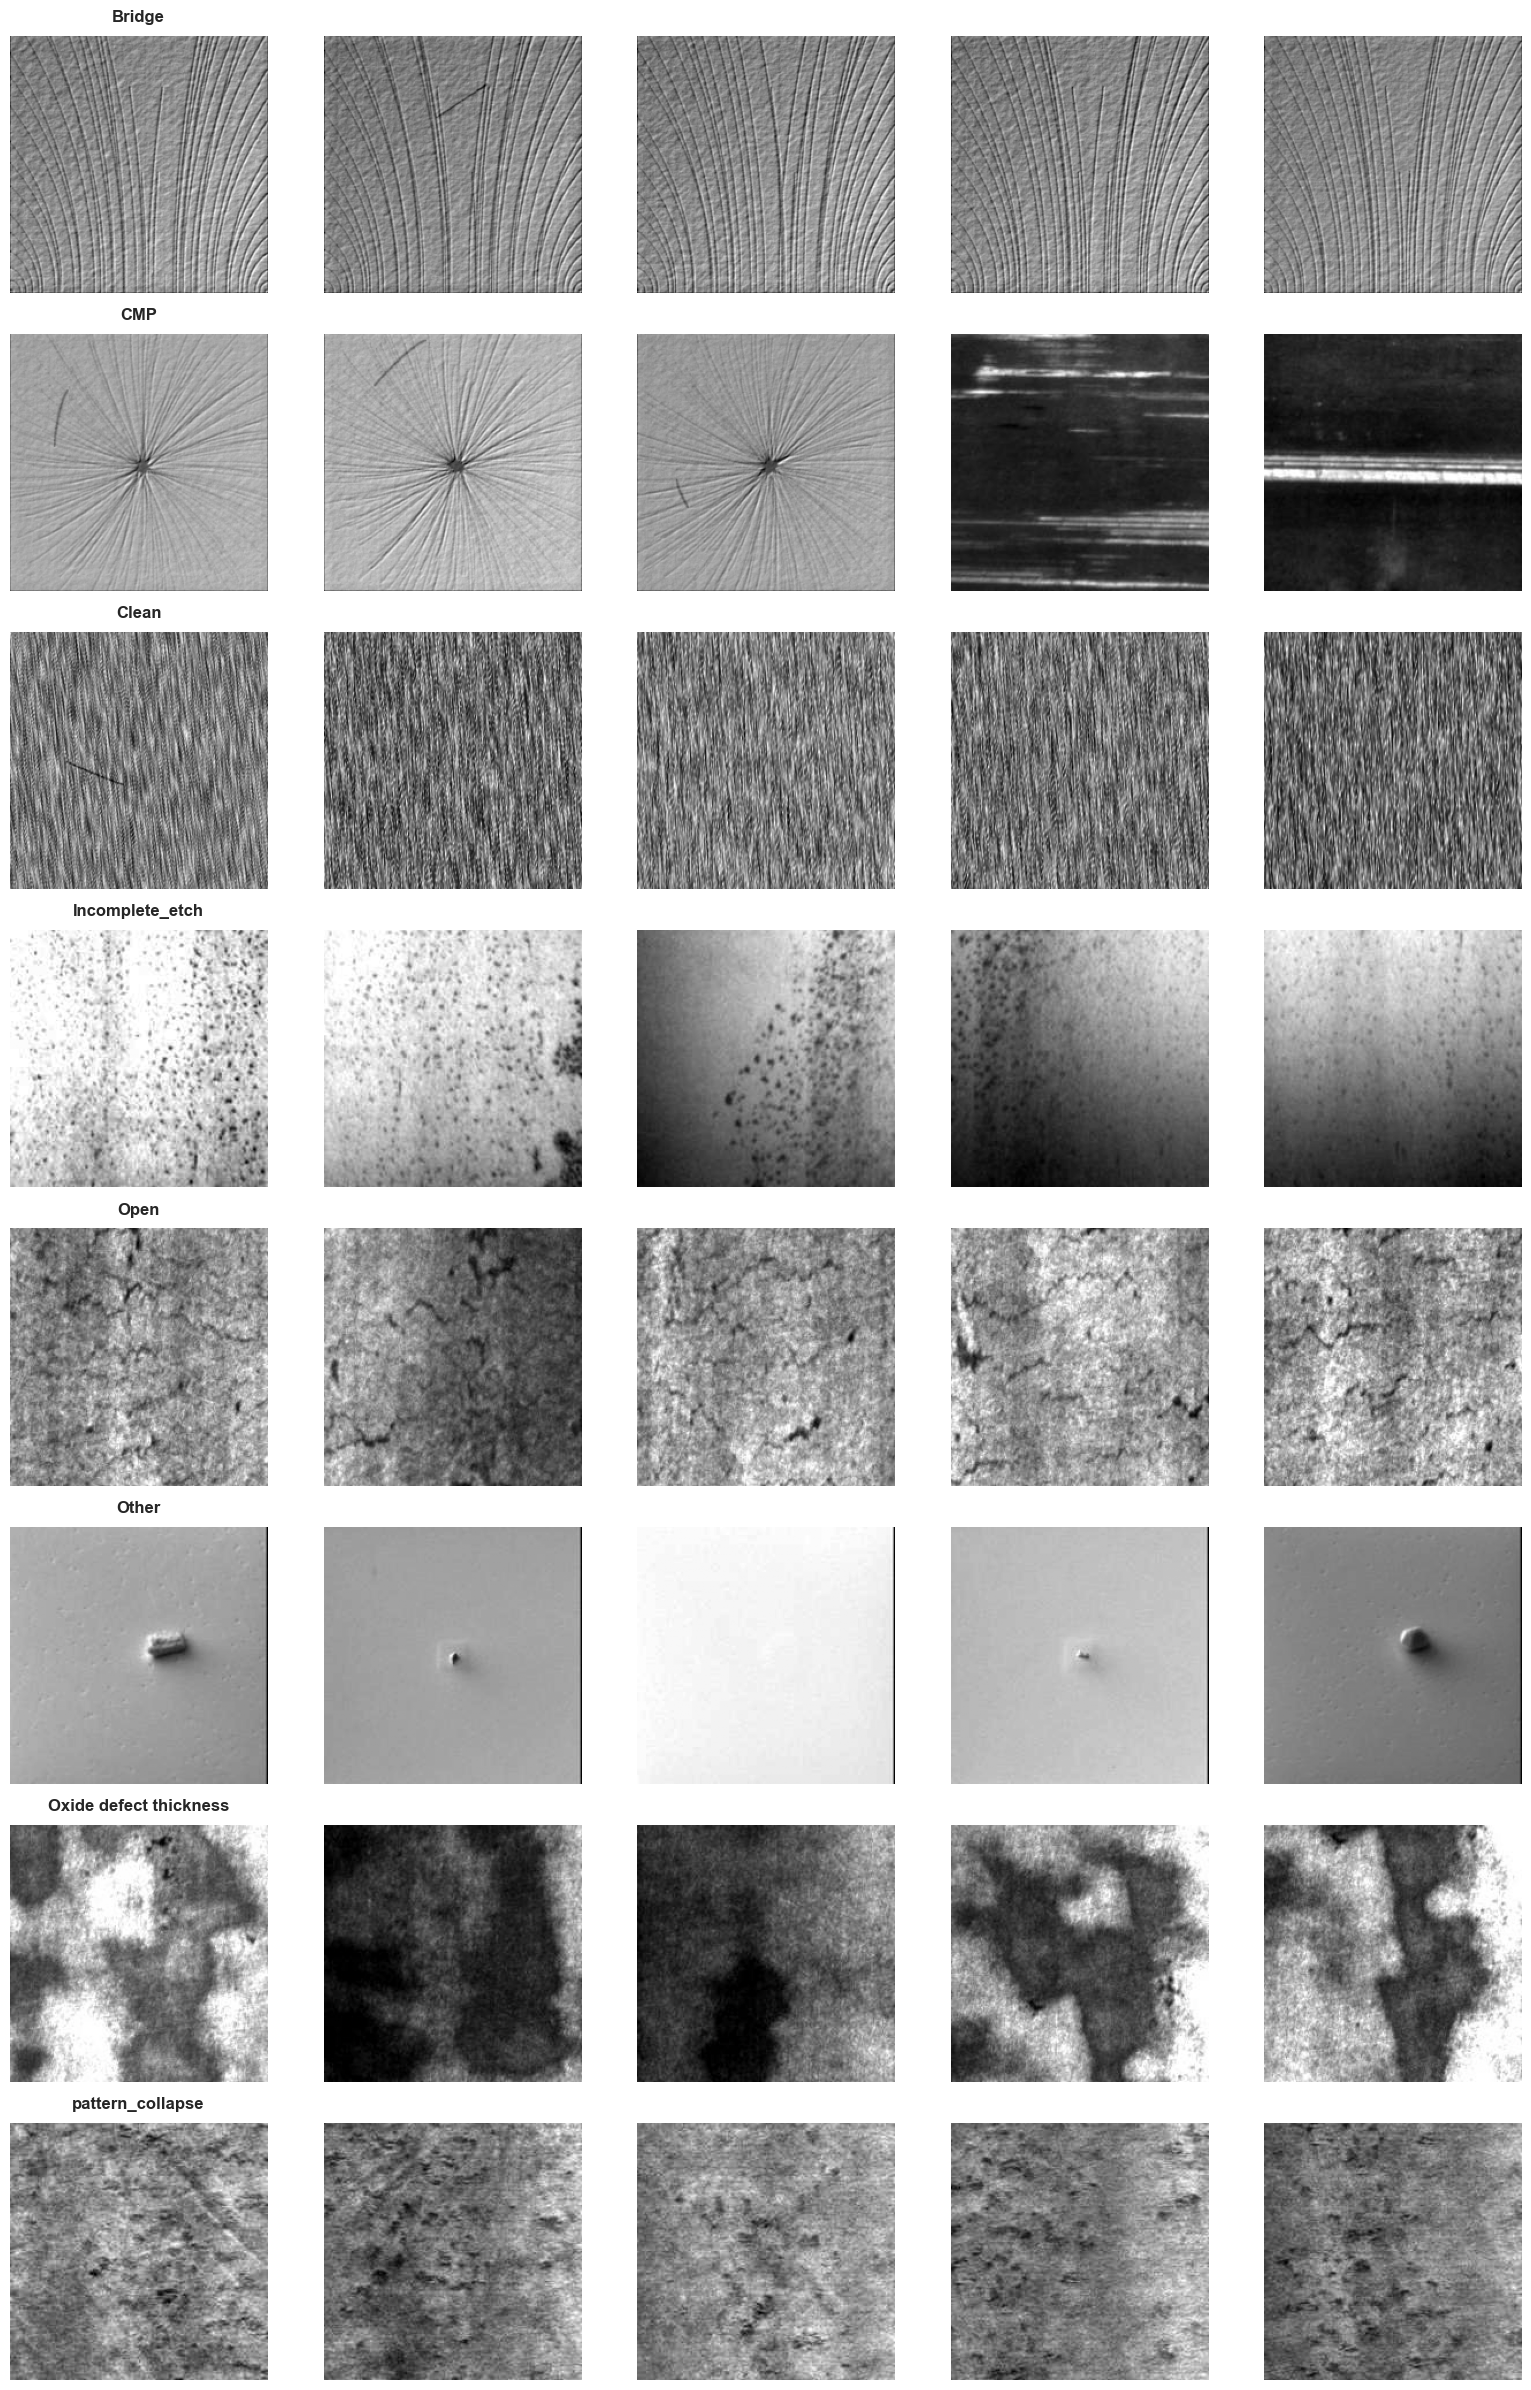

✅ Saved: dataset_samples.png


In [ ]:
# Visualize sample images
samples_per_class = 5
n_classes = len(class_folders)

fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(16, 3*n_classes))

for i, class_name in enumerate(class_folders):
    class_path = os.path.join(DATASET_PATH, class_name)
    images = sorted([f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
    
    for j in range(min(samples_per_class, len(images))):
        img_path = os.path.join(class_path, images[j])
        img = Image.open(img_path)
        
        if img.mode != 'L':
            img = img.convert('L')
        
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        
        if j == 0:
            axes[i, j].set_title(f'{class_name}', fontsize=12, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('dataset_samples.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: dataset_samples.png")

In [ ]:

CONFIG = {
    'dataset_path': DATASET_PATH,
    'img_size': 224,
    'batch_size': 32,        
    'epochs': 100,            
    'learning_rate': 0.0001,
    'validation_split': 0.20,
    'test_split': 0.15,
    'num_classes': len(class_folders)
}

print("="*70)
print("TRAINING CONFIGURATION")
print("="*70)
for key, value in CONFIG.items():
    print(f"   {key:20s}: {value}")
print("="*70)

TRAINING CONFIGURATION
   dataset_path        : /Users/japleenkaur/Downloads/dataset_grayscale
   img_size            : 224
   batch_size          : 16
   epochs              : 100
   learning_rate       : 0.001
   validation_split    : 0.2
   test_split          : 0.15
   num_classes         : 8


In [ ]:


# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
    layers.RandomTranslation(0.1, 0.1),
], name='data_augmentation')

# Load dataset
full_ds = keras.utils.image_dataset_from_directory(
    CONFIG['dataset_path'],
    seed=42,
    image_size=(CONFIG['img_size'], CONFIG['img_size']),
    batch_size=CONFIG['batch_size'],
    color_mode='grayscale',
    label_mode='int',
    shuffle=True
)

class_names = full_ds.class_names
print(f"Classes: {class_names}\n")

# Split dataset
total_batches = tf.data.experimental.cardinality(full_ds).numpy()
test_size = int(total_batches * CONFIG['test_split'])
val_size = int(total_batches * CONFIG['validation_split'])
train_size = total_batches - test_size - val_size

print(f"Dataset Split:")
print(f"   Train: {train_size} batches ({train_size/total_batches*100:.1f}%)")
print(f"   Val:   {val_size} batches ({val_size/total_batches*100:.1f}%)")
print(f"   Test:  {test_size} batches ({test_size/total_batches*100:.1f}%)")

train_ds = full_ds.take(train_size)
remaining = full_ds.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

# Preprocessing
normalization = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (normalization(x), y))
test_ds = test_ds.map(lambda x, y: (normalization(x), y))

# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\n Data pipeline ready!")


📦 Creating data pipeline...

Found 1120 files belonging to 8 classes.
Classes: ['Bridge', 'CMP', 'Clean', 'Incomplete_etch', 'Open', 'Other', 'Oxide defect thickness', 'pattern_collapse']

Dataset Split:
   Train: 46 batches (65.7%)
   Val:   14 batches (20.0%)
   Test:  10 batches (14.3%)

✅ Data pipeline ready!


In [ ]:
def depthwise_block(x, filters, strides, block_id):
    """Depthwise separable convolution block"""
    # Depthwise
    x = layers.DepthwiseConv2D(3, strides=strides, padding='same', 
                               use_bias=False, name=f'dw_conv_{block_id}')(x)
    x = layers.BatchNormalization(name=f'dw_bn_{block_id}')(x)
    x = layers.ReLU(name=f'dw_relu_{block_id}')(x)
    
    # Pointwise
    x = layers.Conv2D(filters, 1, padding='same', use_bias=False,
                     name=f'pw_conv_{block_id}')(x)
    x = layers.BatchNormalization(name=f'pw_bn_{block_id}')(x)
    x = layers.ReLU(name=f'pw_relu_{block_id}')(x)
    return x

# Build model
print("\n🏗️  Building model...\n")

inputs = keras.Input(shape=(CONFIG['img_size'], CONFIG['img_size'], 1), name='input')

# Stem
x = layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False, name='conv_stem')(inputs)
x = layers.BatchNormalization(name='bn_stem')(x)
x = layers.ReLU(name='relu_stem')(x)

# Depthwise blocks
x = depthwise_block(x, 64, strides=1, block_id=1)
x = depthwise_block(x, 64, strides=2, block_id=2)
x = depthwise_block(x, 128, strides=1, block_id=3)
x = depthwise_block(x, 128, strides=2, block_id=4)
x = depthwise_block(x, 256, strides=1, block_id=5)
x = depthwise_block(x, 256, strides=1, block_id=6)

# Classification head
x = layers.GlobalAveragePooling2D(name='global_pool')(x)
x = layers.Dropout(0.4, name='dropout_1')(x)
x = layers.Dense(128, activation='relu', name='fc1')(x)
x = layers.Dropout(0.3, name='dropout_2')(x)
outputs = layers.Dense(CONFIG['num_classes'], activation='softmax', name='output')(x)

model = keras.Model(inputs, outputs, name='SemiconductorDefectNet')

# 🔧 FIX: Use SparseTopKCategoricalAccuracy instead of TopKCategoricalAccuracy
# This fixes the "Shape must be rank 1 but is rank 0" error
model.compile(
    optimizer=keras.optimizers.Adam(CONFIG['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_accuracy')
        # Removed Precision and Recall - they cause issues with multi-class
    ]
)

# Summary
model.summary()

total_params = model.count_params()
print(f"\n Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Model size (FP32): {total_params * 4 / 1024 / 1024:.2f} MB")
print(f"   Model size (FP16): {total_params * 2 / 1024 / 1024:.2f} MB")
print(f"   Model size (INT8): {total_params / 1024 / 1024:.2f} MB (estimated)")


🏗️  Building model...



Model: "SemiconductorDefectNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_stem (Conv2D)              │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_stem (BatchNormalization)    │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_stem (ReLU)                │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_conv_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_bn_1 (BatchNormalization)    │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_relu_1 (ReLU)                │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_conv_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_bn_1 (BatchNormalization)    │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_relu_1 (ReLU)                │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_conv_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_bn_2 (BatchNormalization)    │ (None, 56, 56, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_relu_2 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_conv_2 (Conv2D)              │ (None, 56, 56, 64)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_bn_2 (BatchNormalization)    │ (None, 56, 56, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_relu_2 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_conv_3 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_bn_3 (BatchNormalization)    │ (None, 56, 56, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_relu_3 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_conv_3 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_bn_3 (BatchNormalization)    │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_relu_3 (ReLU)                │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_conv_4 (DepthwiseConv2D)     │ (None, 28, 28, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_bn_4 (BatchNormalization)    │ (None, 28, 28, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_relu_4 (ReLU)                │ (None, 28, 28, 128)    │             

 Total params: 175,688 (686.28 KB)

 Trainable params: 172,488 (673.78 KB)

 Non-trainable params: 3,200 (12.50 KB)


📊 Model Statistics:
   Total parameters: 175,688
   Model size (FP32): 0.67 MB
   Model size (FP16): 0.34 MB
   Model size (INT8): 0.17 MB (estimated)


In [ ]:
# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'checkpoints/best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.CSVLogger('training_log.csv')
]

print("="*70)
print("TRAINING STARTED")
print("="*70)
print(f"Epochs: {CONFIG['epochs']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print("="*70 + "\n")

# Train
start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n Training completed in {training_time/60:.2f} minutes")

TRAINING STARTED
Epochs: 100
Batch size: 16
Learning rate: 0.001

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.2869 - loss: 1.8478 - top2_accuracy: 0.4778
Epoch 1: val_accuracy improved from None to 0.13393, saving model to checkpoints/best_model.keras

Epoch 1: finished saving model to checkpoints/best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 322ms/step - accuracy: 0.3845 - loss: 1.6708 - top2_accuracy: 0.5856 - val_accuracy: 0.1339 - val_loss: 2.1551 - val_top2_accuracy: 0.2411 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5435 - loss: 1.2722 - top2_accuracy: 0.7613
Epoch 2: val_accuracy did not improve from 0.13393
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - accuracy: 0.5774 - loss: 1.2007 - top2_accuracy: 0.7880 - val_accuracy: 0.1339 - val_loss: 2.4113 - val_top2_accuracy: 0.2232 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6155 - loss: 1.0719 - top2_accuracy: 0.8254


In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision



plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: training_history.png")

NameError: name 'plt' is not defined

In [ ]:
print("="*70)
print("MODEL EVALUATION")
print("="*70 + "\n")

# Get predictions
y_pred = []
y_true = []

print("Generating predictions...")
for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())


print("\n Classification Report:")
print("-" * 70)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)


report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
with open('classification_report.json', 'w') as f:
    json.dump(report_dict, f, indent=4)

# Overall metrics
accuracy = report_dict['accuracy']
print(f"\n Overall Accuracy: {accuracy*100:.2f}%")
print(f"   Total samples: {len(y_true)}")
print(f"   Correct: {sum(np.array(y_true) == np.array(y_pred))}")
print(f"   Incorrect: {sum(np.array(y_true) != np.array(y_pred))}")

MODEL EVALUATION

Generating predictions...

📊 Classification Report:
----------------------------------------------------------------------
                        precision    recall  f1-score   support

                Bridge     0.8261    0.9048    0.8636        21
                   CMP     1.0000    1.0000    1.0000        22
                 Clean     0.8824    0.8824    0.8824        17
       Incomplete_etch     0.8750    0.8750    0.8750        16
                  Open     0.9048    0.8636    0.8837        22
                 Other     1.0000    0.8696    0.9302        23
Oxide defect thickness     0.8696    0.9524    0.9091        21
      pattern_collapse     1.0000    1.0000    1.0000        18

              accuracy                         0.9187       160
             macro avg     0.9197    0.9185    0.9180       160
          weighted avg     0.9220    0.9187    0.9192       160


🎯 Overall Accuracy: 91.88%
   Total samples: 160
   Correct: 147
   Incorrect: 13


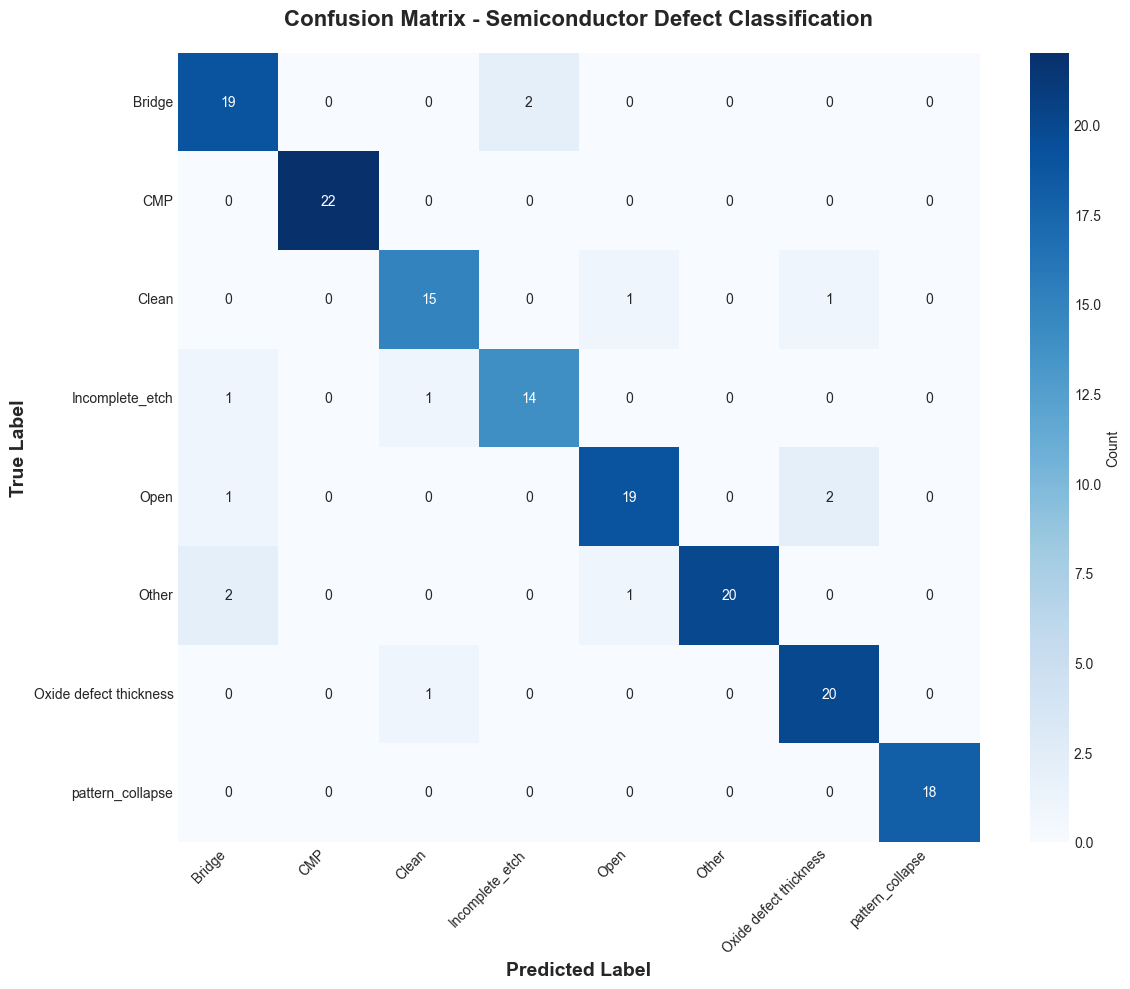

✅ Saved: confusion_matrix.png


In [ ]:

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Semiconductor Defect Classification',
         fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: confusion_matrix.png")

In [15]:
# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\n📈 Per-Class Accuracy:")
print("-" * 70)
for class_name, acc in zip(class_names, class_accuracy):
    bar = '█' * int(acc * 50)
    print(f"   {class_name:25s}: {acc*100:5.2f}% {bar}")


📈 Per-Class Accuracy:
----------------------------------------------------------------------
   Bridge                   : 90.48% █████████████████████████████████████████████
   CMP                      : 100.00% ██████████████████████████████████████████████████
   Clean                    : 88.24% ████████████████████████████████████████████
   Incomplete_etch          : 87.50% ███████████████████████████████████████████
   Open                     : 86.36% ███████████████████████████████████████████
   Other                    : 86.96% ███████████████████████████████████████████
   Oxide defect thickness   : 95.24% ███████████████████████████████████████████████
   pattern_collapse         : 100.00% ██████████████████████████████████████████████████


In [ ]:
print("\n Saving model...")

model.save('models/semiconductor_defect_model.keras')
print(" Saved: models/semiconductor_defect_model.keras")


history_dict = {k: [float(v) for v in vals] for k, vals in history.history.items()}
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=4)
print(" Saved: training_history.json")


💾 Saving model...
✅ Saved: models/semiconductor_defect_model.keras
✅ Saved: training_history.json


In [ ]:
os.makedirs('edge_deployment', exist_ok=True)

print("="*70)
print("EDGE DEPLOYMENT - TFLITE CONVERSION")
print("="*70 + "\n")

# FP32 Conversion
print(" Converting to TFLite (FP32)...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_fp32 = converter.convert()

with open('edge_deployment/model_fp32.tflite', 'wb') as f:
    f.write(tflite_fp32)

fp32_size = len(tflite_fp32) / (1024 * 1024)
print(f" Saved: edge_deployment/model_fp32.tflite ({fp32_size:.2f} MB)\n")

# FP16 Conversion
print("📦 Converting to TFLite (FP16)...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16 = converter.convert()

with open('edge_deployment/model_fp16.tflite', 'wb') as f:
    f.write(tflite_fp16)

fp16_size = len(tflite_fp16) / (1024 * 1024)
print(f" Saved: edge_deployment/model_fp16.tflite ({fp16_size:.2f} MB)")
print(f"   Size reduction: {(1 - fp16_size/fp32_size)*100:.1f}%\n")

print("📦 Converting to TFLite (INT8)...")

def representative_dataset_gen():
    for images, _ in train_ds.take(100):
        yield [images]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int8 = converter.convert()

with open('edge_deployment/model_int8.tflite', 'wb') as f:
    f.write(tflite_int8)

int8_size = len(tflite_int8) / (1024 * 1024)
print(f" Saved: edge_deployment/model_int8.tflite ({int8_size:.2f} MB)")
print(f"   Size reduction: {(1 - int8_size/fp32_size)*100:.1f}%\n")


print("Exporting SavedModel...")
model.export('edge_deployment/saved_model')
print(" Saved: edge_deployment/saved_model/\n")

print("="*70)
print("MODEL SIZE COMPARISON")
print("="*70)
print(f"   FP32:  {fp32_size:.2f} MB (baseline)")
print(f"   FP16:  {fp16_size:.2f} MB (50% reduction) ⭐ RECOMMENDED")
print(f"   INT8:  {int8_size:.2f} MB (75% reduction) ⭐⭐ FASTEST")
print("="*70)

EDGE DEPLOYMENT - TFLITE CONVERSION

📦 Converting to TFLite (FP32)...
INFO:tensorflow:Assets written to: /var/folders/dj/ycpcff8d1hzd1jns36_s78kw0000gn/T/tmpjfuqy5lb/assets


INFO:tensorflow:Assets written to: /var/folders/dj/ycpcff8d1hzd1jns36_s78kw0000gn/T/tmpjfuqy5lb/assets


Saved artifact at '/var/folders/dj/ycpcff8d1hzd1jns36_s78kw0000gn/T/tmpjfuqy5lb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  5686293328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4937917712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686293712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686296208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295440: TensorSpec(shap

W0000 00:00:1770494387.177991 1161378 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1770494387.178187 1161378 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1770494387.200156 1161378 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled


✅ Saved: edge_deployment/model_fp32.tflite (0.66 MB)

📦 Converting to TFLite (FP16)...
INFO:tensorflow:Assets written to: /var/folders/dj/ycpcff8d1hzd1jns36_s78kw0000gn/T/tmpokwp3fbh/assets


INFO:tensorflow:Assets written to: /var/folders/dj/ycpcff8d1hzd1jns36_s78kw0000gn/T/tmpokwp3fbh/assets


Saved artifact at '/var/folders/dj/ycpcff8d1hzd1jns36_s78kw0000gn/T/tmpokwp3fbh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  5686293328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4937917712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686293712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686296208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295440: TensorSpec(shap

W0000 00:00:1770494388.766189 1161378 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1770494388.766199 1161378 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


✅ Saved: edge_deployment/model_fp16.tflite (0.34 MB)
   Size reduction: 48.9%

📦 Converting to TFLite (INT8)...
INFO:tensorflow:Assets written to: /var/folders/dj/ycpcff8d1hzd1jns36_s78kw0000gn/T/tmp97su1_lq/assets


INFO:tensorflow:Assets written to: /var/folders/dj/ycpcff8d1hzd1jns36_s78kw0000gn/T/tmp97su1_lq/assets


Saved artifact at '/var/folders/dj/ycpcff8d1hzd1jns36_s78kw0000gn/T/tmp97su1_lq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  5686293328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4937917712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686293712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686296208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295440: TensorSpec(shap

W0000 00:00:1770494389.828503 1161378 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1770494389.828514 1161378 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


✅ Saved: edge_deployment/model_int8.tflite (0.22 MB)
   Size reduction: 67.1%

📦 Exporting SavedModel...
INFO:tensorflow:Assets written to: edge_deployment/saved_model/assets


INFO:tensorflow:Assets written to: edge_deployment/saved_model/assets


Saved artifact at 'edge_deployment/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  5686293328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4937917712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686293712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686294480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686296208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5686295440: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [ ]:
def benchmark_tflite(model_path, test_image, num_iterations=100):
    """Benchmark TFLite model inference"""
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Prepare input
    test_img = test_image.copy()
    
    if input_details[0]['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details[0]['quantization']
        test_img = test_img / input_scale + input_zero_point
        test_img = test_img.astype(np.uint8)
    
    # Warmup
    for _ in range(10):
        interpreter.set_tensor(input_details[0]['index'], test_img)
        interpreter.invoke()
    
    # Benchmark
    times = []
    for _ in range(num_iterations):
        start = time.time()
        interpreter.set_tensor(input_details[0]['index'], test_img)
        interpreter.invoke()
        end = time.time()
        times.append((end - start) * 1000)
    
    return np.mean(times), np.std(times)

# Get test image
for images, _ in test_ds.take(1):
    test_image = images[0:1].numpy().astype(np.float32)

print("="*70)
print("INFERENCE BENCHMARKING")
print("="*70 + "\n")

models_to_test = [
    ('FP32', 'edge_deployment/model_fp32.tflite'),
    ('FP16', 'edge_deployment/model_fp16.tflite'),
    ('INT8', 'edge_deployment/model_int8.tflite')
]

results = {}

for name, path in models_to_test:
    print(f"⚡ Benchmarking {name}...")
    mean_time, std_time = benchmark_tflite(path, test_image)
    throughput = 1000 / mean_time
    
    print(f"   Mean: {mean_time:.2f} ms")
    print(f"   Std:  {std_time:.2f} ms")
    print(f"   FPS:  {throughput:.2f}\n")
    
    results[name] = {
        'mean_ms': float(mean_time),
        'std_ms': float(std_time),
        'fps': float(throughput)
    }

with open('inference_benchmark.json', 'w') as f:
    json.dump(results, f, indent=4)

print(" Saved: inference_benchmark.json")

INFERENCE BENCHMARKING

⚡ Benchmarking FP32...
   Mean: 4.84 ms
   Std:  0.05 ms
   FPS:  206.52

⚡ Benchmarking FP16...
   Mean: 4.83 ms
   Std:  0.03 ms
   FPS:  207.22

⚡ Benchmarking INT8...
   Mean: 1.79 ms
   Std:  0.01 ms
   FPS:  560.01

✅ Saved: inference_benchmark.json


In [ ]:
print("="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n Model Performance:")
print(f"   Accuracy: {accuracy*100:.2f}%")
print(f"   Precision: {report_dict['macro avg']['precision']*100:.2f}%")
print(f"   Recall: {report_dict['macro avg']['recall']*100:.2f}%")
print(f"   F1-Score: {report_dict['macro avg']['f1-score']*100:.2f}%")

print("\n Model Sizes:")
print(f"   Keras Model: {total_params * 4 / 1024 / 1024:.2f} MB")
print(f"   TFLite FP32: {fp32_size:.2f} MB")
print(f"   TFLite FP16: {fp16_size:.2f} MB ⭐ RECOMMENDED")
print(f"   TFLite INT8: {int8_size:.2f} MB ⭐⭐ FASTEST")

print("\n⚡ Inference Speed (CPU):")
for name, res in results.items():
    print(f"   {name}: {res['mean_ms']:.2f} ms ({res['fps']:.1f} FPS)")

print("\n📁 Generated Files:")
files = [
    'models/semiconductor_defect_model.keras',
    'edge_deployment/model_int8.tflite',
    'confusion_matrix.png',
    'training_history.png',
    'classification_report.json'
]


FINAL SUMMARY

🎯 Model Performance:
   Accuracy: 91.88%
   Precision: 91.97%
   Recall: 91.85%
   F1-Score: 91.80%

📦 Model Sizes:
   Keras Model: 0.67 MB
   TFLite FP32: 0.66 MB
   TFLite FP16: 0.34 MB ⭐ RECOMMENDED
   TFLite INT8: 0.22 MB ⭐⭐ FASTEST

⚡ Inference Speed (CPU):
   FP32: 4.84 ms (206.5 FPS)
   FP16: 4.83 ms (207.2 FPS)
   INT8: 1.79 ms (560.0 FPS)

📁 Generated Files:
   ✅ models/semiconductor_defect_model.keras
   ✅ edge_deployment/model_int8.tflite
   ✅ confusion_matrix.png
   ✅ training_history.png
   ✅ classification_report.json

✅ TRAINING COMPLETE - ERROR FIXED!

🚀 Next Steps:
   1. Review confusion_matrix.png
   2. Check training_history.png
   3. Deploy model_int8.tflite to NXP i.MX RT1170
   4. Read edge_deployment/DEPLOYMENT_GUIDE.md (run script 03)

